In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(data.head())
print(test_data.head())

   id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   0   58    1                4  152          239             0            0   
1   1   52    1                1  125          325             0            2   
2   2   56    0                2  160          188             0            2   
3   3   44    0                3  134          229             0            2   
4   4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium Heart Disease  
0                        2         7      Presence  
1                        0         3       Absence  
2    

In [3]:
# Exploring missing data
print(data.isnull().sum())
print("separation")
print(test_data.isnull().sum()) 

data.drop(columns=["id"],inplace=True)

id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64
separation
id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
dtype: int64


In [4]:
# Chest pain
# Value between 1 -4
data["Chest pain type"].describe()

count    630000.000000
mean          3.312752
std           0.851615
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           4.000000
Name: Chest pain type, dtype: float64

In [ ]:
# Exploring Thallium
# Value exists from 3-7
data["Thallium"].describe()

count    630000.000000
mean          4.618873
std           1.950007
min           3.000000
25%           3.000000
50%           3.000000
75%           7.000000
max           7.000000
Name: Thallium, dtype: float64

In [ ]:
# Exploring Number of major vessels
# Value exists from 0-3
data['Number of vessels fluro'].describe()

count    630000.000000
mean          0.451040
std           0.798549
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: Number of vessels fluro, dtype: float64

# RF model 


Used to check feature significance, unsupervised learning model good for exploring key relationships. Consider dropping everything else to prevent overfitting





In [ ]:
X_train = data.drop('Heart Disease', axis=1)
y_train = data['Heart Disease']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(test_data)
print(predictions)
accuracy = rf.score(X_train, y_train)
print(f"Training Accuracy: {accuracy}")

['Presence' 'Absence' 'Presence' ... 'Absence' 'Absence' 'Absence']
Training Accuracy: 0.9999746031746032


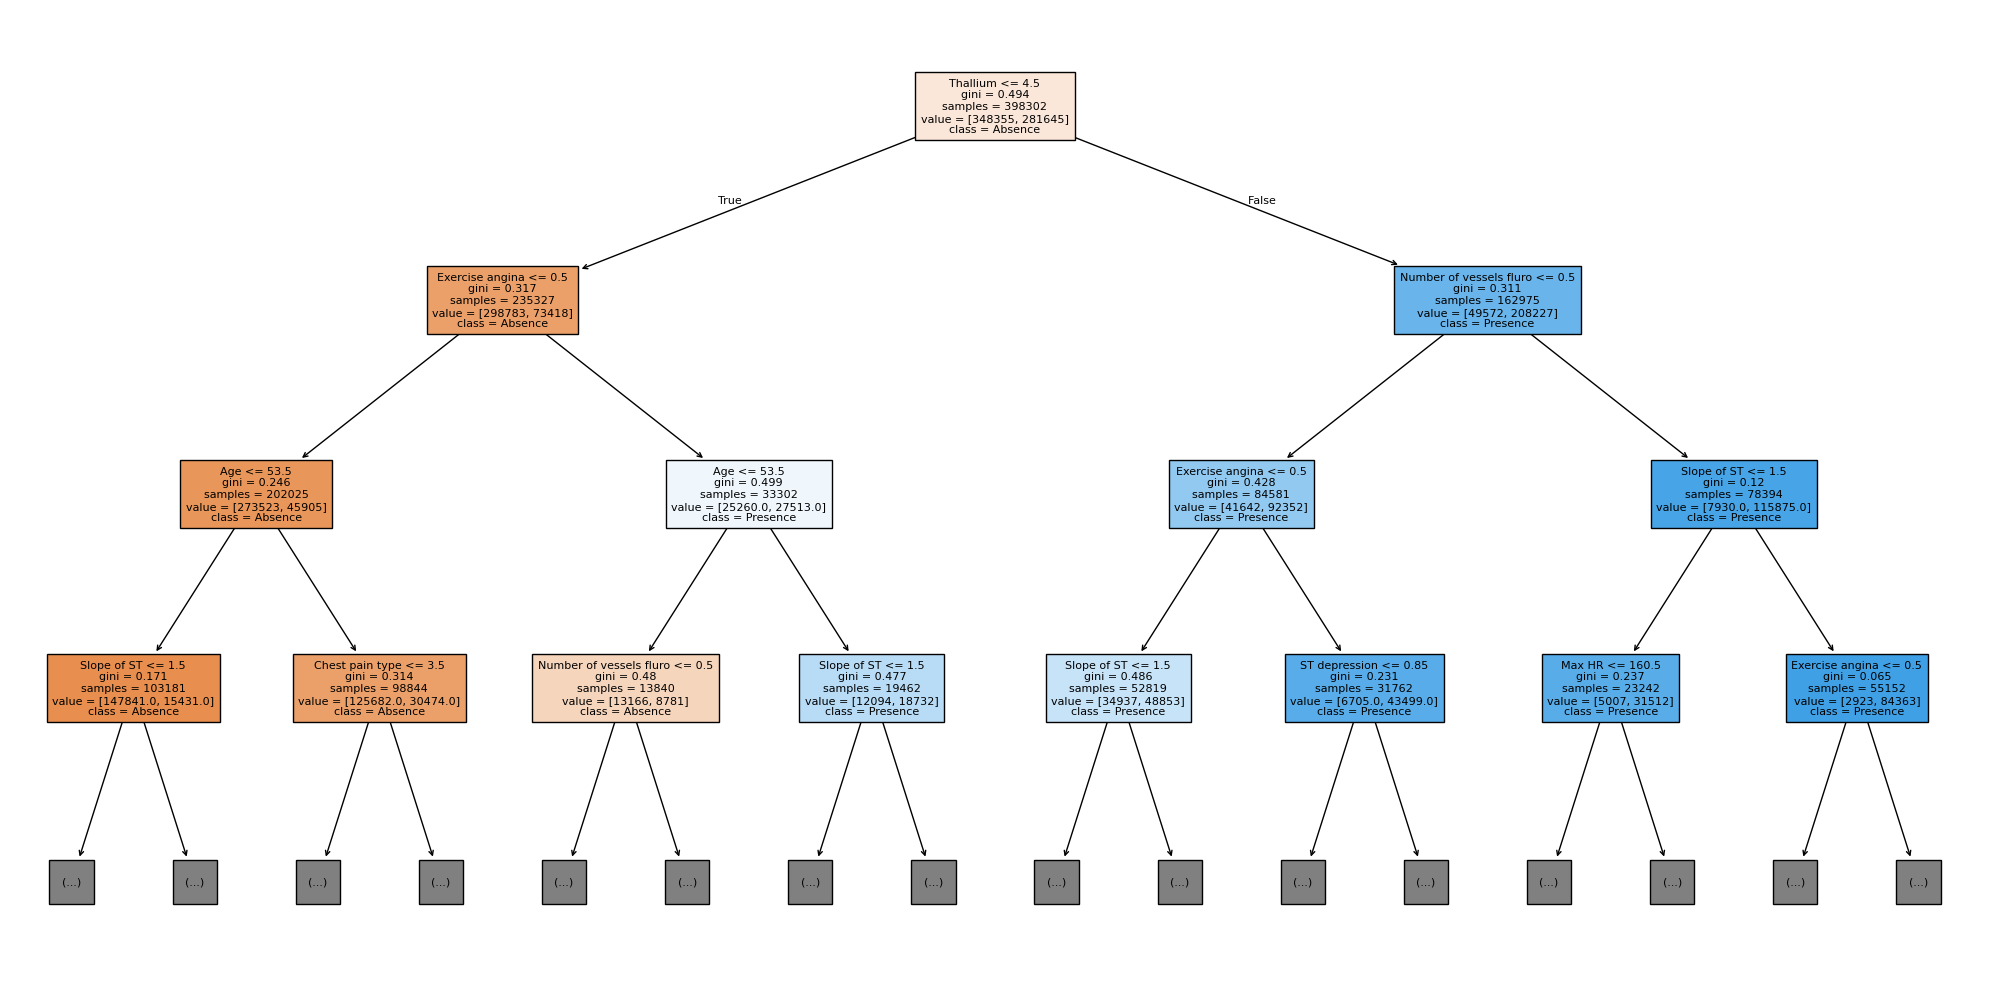

In [ ]:
est=rf.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(est,
           feature_names=X_train.columns,
           class_names=rf.classes_ ,
           filled=True,
           max_depth=3,
           fontsize=8)
plt.tight_layout()
plt.show()

# Description of Features

- Age 
- Sex
- Chest pain type
- BP
- Cholesterol
- FBS over 120
- EKG result
- Max HR -higher heart rate has greater correlation to heart disease
- Exercise angina - chest pain or discomfort that happens when your heart isnt receiving enough blood, potential symptom of heart disease
- ST depression
- Slope of ST
- Number of vessels fluro
- Thallium

# Simple Feature Engineering

Great feature set — this is basically the classic UCI heart disease core, which means **smart feature engineering can move the needle a lot** 👍
I’ll go feature-by-feature and then suggest **interaction + composite features** that tend to work especially well with Random Forests.

---

## 1. Age-based features (very high ROI)

**Raw Age is good, but thresholds are better for trees.**

Try:

* **Age bins**  `<40`, `40–49`, `50–59`, `60+`
* **Risk flags**  `age_over_50` `age_over_60`
* **Age × sex**
  * Heart disease risk rises earlier in males

Derived:

```text
age_bin
age_over_50
age_sex_interaction = age * sex
```

---

## 2. Sex (binary, but underused)

Sex alone is weak — interactions matter.

Engineer:

* `male_and_exercise_angina`
* `male_and_high_cholesterol`
* `female_and_atypical_chest_pain`

These capture different symptom presentations.

---

## 3. Chest pain type (goldmine)

Chest pain type is one of the strongest predictors.

First:

* **One-hot encode** (do not leave as 0/1/2/3)

Then add:

* `is_typical_angina`
* `is_asymptomatic`
* `angina_like_pain` (group typical + atypical)

Trees love grouped indicators.

---

## 4. Blood Pressure (BP)

Raw BP is noisy.

Engineer:

* **BP categories**

  * Normal: `<120`
  * Elevated: `120–129`
  * High: `130+`
* Flags:

  * `hypertension = BP >= 130`
  * `severe_hypertension = BP >= 160`

Interactions:

* `age × BP`
* `hypertension × exercise_angina`

---

## 5. Cholesterol (very nonlinear risk)

Raw cholesterol is less informative than ranges.

Engineer:

* **Cholesterol risk bins**

  * Normal: `<200`
  * Borderline: `200–239`
  * High: `240+`
* Flags:

  * `high_cholesterol`
  * `very_high_cholesterol`

Ratios:

* `cholesterol / age`
* `cholesterol × BP` (metabolic stress proxy)

---

## 6. Fasting Blood Sugar over 120 (FBS)

Binary, but clinically meaningful.

Engineer:

* `metabolic_risk = (FBS_over_120 == 1) & (cholesterol >= 240)`
* `fbs_and_hypertension`

This helps RF detect metabolic syndrome patterns.

---

## 7. EKG result

EKG is often ordinal or categorical.

First:

* One-hot encode (normal / ST abnormality / LV hypertrophy)

Then:

* `abnormal_ekg`
* `ekg_abnormal_and_exercise_angina`
* `ekg_abnormal_and_low_max_hr`

---

## 8. Max Heart Rate (Max HR)

One of the strongest continuous predictors.

Engineer:

* **Age-adjusted heart rate**

  * `expected_max_hr = 220 - age`
  * `hr_ratio = max_hr / expected_max_hr`
* Flags:

  * `low_hr_ratio < 0.85`
  * `very_low_hr_ratio < 0.7`

Interactions:

* `exercise_angina × low_hr_ratio`

---

## 9. Exercise-induced Angina

Binary, but very informative with context.

Engineer:

* `angina_and_low_hr`
* `angina_and_high_bp`
* `angina_and_abnormal_ekg`

---

## 10. Composite risk features (huge RF boost)

These often outperform individual features.

### a) Cardiovascular risk count

```text
risk_count = sum(
  age_over_50,
  male,
  hypertension,
  high_cholesterol,
  FBS_over_120,
  abnormal_ekg,
  exercise_angina
)
```

### b) High-risk patient flag

```text
high_risk = (risk_count >= 4)
```

---


## 12. What usually gives the biggest lift (from experience)

If I had to prioritize:

1. **Chest pain grouping**
2. **Age-adjusted max HR ratio**
3. **BP + cholesterol bins**
4. **Interaction features with exercise angina**
5. **Composite risk score**



In [ ]:
# Chest pain grouping
